In [1]:
%pylab inline
import time
import os 

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision
from torchvision import transforms

from PIL import Image
from collections import OrderedDict

Populating the interactive namespace from numpy and matplotlib


# VGG architecture

In [2]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        #construct VGG layers
        
        #1st convolutional layer
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        #2nd convolutional layer        
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        #3rd convolutional layer         
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        #4th convolutional layer 
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        
        #5th convolutional layer
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        
        #use average pooling (gives better results according to the paper)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)      
        self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.pool5 = nn.AvgPool2d(kernel_size=2, stride=2)
          
    def forward(self, x, output_params):
        #forward propagation
        #store weights in a dictionary
        
        output_weights = {}

        #Block 1
        output_weights['conv_layer1_1'] = F.relu(self.conv1_1(x))
        output_weights['conv_layer1_2'] = F.relu(self.conv1_2(output_weights['conv_layer1_1']))
        output_weights['pooling_layer1'] = self.pool1(output_weights['conv_layer1_2'])

        #Block 2
        output_weights['conv_layer2_1'] = F.relu(self.conv2_1(output_weights['pooling_layer1']))
        output_weights['conv_layer2_2'] = F.relu(self.conv2_2(output_weights['conv_layer2_1']))
        output_weights['pooling_layer2'] = self.pool2(output_weights['conv_layer2_2'])

        #Block 3
        output_weights['conv_layer3_1'] = F.relu(self.conv3_1(output_weights['pooling_layer2']))
        output_weights['conv_layer3_2'] = F.relu(self.conv3_2(output_weights['conv_layer3_1']))
        output_weights['conv_layer3_3'] = F.relu(self.conv3_3(output_weights['conv_layer3_2']))
        output_weights['conv_layer3_4'] = F.relu(self.conv3_4(output_weights['conv_layer3_3']))
        output_weights['pooling_layer3'] = self.pool3(output_weights['conv_layer3_4'])

        #Block 4
        output_weights['conv_layer4_1'] = F.relu(self.conv4_1(output_weights['pooling_layer3']))
        output_weights['conv_layer4_2'] = F.relu(self.conv4_2(output_weights['conv_layer4_1']))
        output_weights['conv_layer4_3'] = F.relu(self.conv4_3(output_weights['conv_layer4_2']))
        output_weights['conv_layer4_4'] = F.relu(self.conv4_4(output_weights['conv_layer4_3']))
        output_weights['pooling_layer4'] = self.pool4(output_weights['conv_layer4_4'])

        #Block 5
        output_weights['conv_layer5_1'] = F.relu(self.conv5_1(output_weights['pooling_layer4']))
        output_weights['conv_layer5_2'] = F.relu(self.conv5_2(output_weights['conv_layer5_1']))
        output_weights['conv_layer5_3'] = F.relu(self.conv5_3(output_weights['conv_layer5_2']))
        output_weights['conv_layer5_4'] = F.relu(self.conv5_4(output_weights['conv_layer5_3']))
        output_weights['pooling_layer5'] = self.pool5(output_weights['conv_layer5_4'])

        return [output_weights[param] for param in output_params] #Return a list of the specified parameter weights

# Define Gram matrix and loss

In [3]:
class GramMatrix(nn.Module):
    def forward(self, input):
        batch, channel, height, width = input.size()
        F = input.view(batch, channel, height*width)  #flatten the matrix
        '''
          F: bxcx(h*w); F.transpose(1,2): bx(h*w)xc 
          Perform batch matrix multiplication using only the last 2
          dimensions
        '''
        gram_matrix = torch.bmm(F, F.transpose(1,2)) 
        gram_matrix.div_(height*width)
        return gram_matrix

class GramMatrixStyleLoss(nn.Module):
    def forward(self, input, target):
      '''
        I have used the MSE loss here (as detailed in the 
        original paper)
      '''
      return (nn.MSELoss()(GramMatrix()(input), target))

# Pre and post processing of the images

In [4]:
size_of_img = 512     #size of image that goes into the VGG network 

pre_process = transforms.Compose([transforms.Scale(size_of_img),                           #Resize image
                           transforms.ToTensor(),                                          #Transform to torch tensor
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]),      #Change color channels from RGB to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #Normalize using imagenet parameters
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),                       #Rescale input
                          ])

post_process = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),                      #Bring pixel values back to normal
                           transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961],  #"Un-normalize" the image
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]),          #Revert color channels to RGB
                           ])


post_process_image = transforms.Compose([transforms.ToPILImage()])

def process_img(tensor): # to clip results in the range [0,1]
    final_img_tensor = post_process(tensor)
    final_img_tensor[final_img_tensor>1] = 1    #All tensor entries > 1 = 1
    final_img_tensor[final_img_tensor<0] = 0    #All tensor entries < 0 = 0
    final_img = post_process_image(final_img_tensor)
    return final_img

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


# Mount the drive for loading VGG weights and images

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Prepare the network

In [6]:
vgg_network = VGG()

vgg_network.load_state_dict(torch.load("/content/drive/MyDrive/image-style-transfer/vgg_conv.pth")) #File path to the pre-trained VGG network loaded into a dictionary

for param in vgg_network.parameters():
    param.requires_grad = False

if torch.cuda.is_available():
    vgg_network.cuda() #Put the model in the GPU if applicable

# Load images

In [7]:
img_file_path = "/content/drive/MyDrive/image-style-transfer/Images/" #file path to the image directory 
img_loc = [img_file_path, img_file_path]                              #[style_image, content_image]
img_labels = ['vangogh_starry_night.jpeg', 'Tuebingen_Neckarfront.jpeg']

img_list = [Image.open(img_loc[i] + name) for i,name in enumerate(img_labels)]

#Pre-process all images
pre_processed_img = [pre_process(img) for img in img_list]

#Check for GPU access
if torch.cuda.is_available():
    pre_processed_img = [Variable(img.unsqueeze(0).cuda()) for img in pre_processed_img]
else:
    pre_processed_img = [Variable(img.unsqueeze(0)) for img in pre_processed_img]
style_image, content_image = pre_processed_img

#clone image data
cloned_data = Variable(content_image.data.clone(), requires_grad=True)

# Sanity check

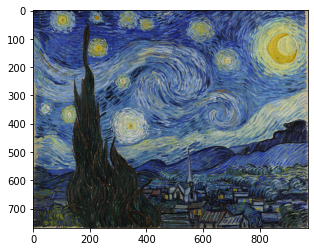

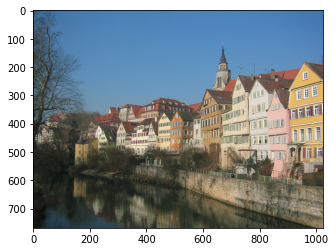

In [8]:
for img in img_list:
    imshow(img);show()

# Define layers, loss functions and optimizers

In [9]:
style_layers = ['conv_layer1_1','conv_layer2_1','conv_layer3_1','conv_layer4_1', 'conv_layer5_1'] 
content_layers = ['conv_layer4_2']
layer_loss  = style_layers + content_layers

net_loss =  [GramMatrixStyleLoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers) 

#Use the GPU if appicable
if torch.cuda.is_available():
    net_loss = [loss_fn.cuda() for loss_fn in net_loss]
    
#set initial weights
style_weights = [1e3/n**2 for n in [64,128,256,512,512]]
content_weights = [1e0]
weights = style_weights + content_weights

#set target weights
style_targets = [GramMatrix()(A).detach() for A in vgg_network(style_image, style_layers)] #use gradients
content_targets = [A.detach() for A in vgg_network(content_image, content_layers)]
target_weights = style_targets + content_targets

# Run style transfer

Iteration: 50, loss: 73082.984375
Iteration: 100, loss: 51209.453125
Iteration: 150, loss: 45779.515625
Iteration: 200, loss: 43363.621094
Iteration: 250, loss: 41969.343750
Iteration: 300, loss: 41094.382812
Iteration: 350, loss: 40490.476562
Iteration: 400, loss: 40060.417969
Iteration: 450, loss: 39742.777344
Iteration: 500, loss: 39500.636719


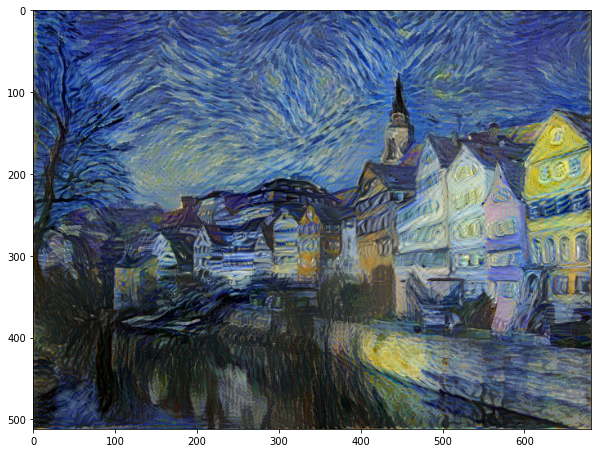

In [10]:
max_epochs = 500
epoch_step_show = 50
optimizer = optim.LBFGS([cloned_data]);

num_epoch=[0]

while num_epoch[0] <= max_epochs:

    def compute_total_loss():
        optimizer.zero_grad()   #restart looping without previous gradients
        output = vgg_network(cloned_data, layer_loss )
        loss_per_layer = [weights[a] * net_loss[a](A, target_weights[a]) for a,A in enumerate(output)]
        total_loss = sum(loss_per_layer)
        total_loss.backward()
        num_epoch[0]+=1

        #print out the losses after every epoch_step_show iterations
        if (num_epoch[0]%epoch_step_show == (epoch_step_show-1)):
            print('Iteration: %d, loss: %f'%(num_epoch[0]+1, total_loss.item()))
        return total_loss
    
    optimizer.step(compute_total_loss)
    
#display transferred image
output_img = process_img(cloned_data.data[0].cpu().squeeze())
imshow(output_img)
gcf().set_size_inches(10,10)